## formulate question

In [2]:
# seperate legitimate emails from spam emails

# Notebook import

In [55]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

import warnings
from bs4 import MarkupResemblesLocatorWarning
from bs4 import BeautifulSoup

from wordcloud import WordCloud

from PIL import Image

In [2]:
# import nltk
# nltk.download('punkt_tab')

In [5]:
# nltk.download('gutenberg')
# nltk.download('shakespeare')

## Constants

In [58]:
Example_file = 'SpamData/01_Processing/practice_email.txt'

spam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
easy_nonspam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
easy_nonspam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

json = 'SpamData/email-txt-data.csv'
whale_file = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
skull_file = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
thumbs_up_file = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
thumbs_down_file = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

#font file
custom_font =  'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
vocab_size = 2500

training_data_file = 'SpamData/02_Training/Train-data.txt'
testing_data_file = 'SpamData/03_Testing/Test-data.txt'

spam_cat = 1
ham_cat = 0

# Reading Files

In [4]:
stream = open(Example_file , encoding='latin-1')
is_body = False
lines =[]

stream.close()

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

# Generator Function

In [6]:
def generate_square(N):
  for my_number in range(N):
    yield my_number**2

In [7]:
for i in generate_square(5):
  print(i , end='->')

0->1->4->9->16->

# Email Body Extraction

In [8]:
from os import walk
from os.path import join
def email_body_generator(path):
  for root ,dirnames , filenames in walk(path):
    for file_name in filenames:
        # Construct the full file path by joining the root directory and the file name
        file_path = join(root, file_name)
        stream = open(file_path , encoding='latin-1')
        is_body = False
        lines =[]
        for line in stream:
            if is_body:
                lines.append(line)
            elif line == '\n':
                is_body = True
        stream.close()
        email_body = '\n'.join(lines)
        yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []

    for file_name, email_body in email_body_generator(path):
        clean_body = email_body.replace("\n", " ").strip()  # \n ko space me badal diya
        rows.append({'MESSAGE': clean_body, 'CATEGORY': classification})
        row_names.append(file_name)

    return pd.DataFrame(rows, index=row_names)


In [10]:
spam_emails = df_from_directory(spam_1_path, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(spam_2_path, 1)])
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer! http://www.adcli...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer! http://www.adcli...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these: 1) Slim Down ...,1


In [11]:
spam_emails.shape

(1896, 2)

In [12]:
ham_emails = df_from_directory(easy_nonspam_1_path, 0)
ham_emails = pd.concat([ham_emails, df_from_directory(easy_nonspam_2_path, 0)])
ham_emails.shape

(3900, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails])
print('shape of data is', data.shape)

shape of data is (5796, 2)


In [14]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there, Now this is probably of no use to...",0


# Data Cleaning : Checking for missing values

In [15]:
# check if any messages bodies are null
data['MESSAGE'].isnull().values.any()

np.False_

In [16]:
(data.MESSAGE.str.len()==0).any()

np.False_

In [17]:
(data.MESSAGE.str.len()==0).sum()

np.int64(0)

In [18]:
data.MESSAGE.isnull().sum()

np.int64(0)

In [19]:
type((data.MESSAGE.str.len()==0))

pandas.core.series.Series

In [20]:
data[data.MESSAGE.str.len()==0].index

Index([], dtype='object')

In [21]:
data[998:1000]

,MESSAGE,CATEGORY
00500.87320162ab5b79f67978406cf909c3d1,As to Want to refinance? Fill out th...,1
00501.32679091b0520132ad888ef3b134ce48,"Dear Sirs, We know your esteemed company in b...",1


# Remove System file entries from dataframe

In [21]:
#data.drop(['cmds'], inplace=True)

In [22]:
data[998:1000]

,MESSAGE,CATEGORY
00500.87320162ab5b79f67978406cf909c3d1,As to Want to refinance? Fill out th...,1
00501.32679091b0520132ad888ef3b134ce48,"Dear Sirs, We know your esteemed company in b...",1


In [23]:
data.shape

(5796, 2)

# Add documents ids to track email in dataset

In [24]:
document_ids=range(0,len(data.index))
data['doc_id']=document_ids

In [25]:
data['file_name']=data.index
data.set_index('doc_id',inplace=True)
data.head()

,MESSAGE,CATEGORY,file_name
doc_id,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer! http://www.adcli...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer! http://www.adcli...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these: 1) Slim Down ...,1,00005.57696a39d7d84318ce497886896bf90d


In [26]:
data.tail()

,MESSAGE,CATEGORY,file_name
doc_id,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there, Now this is probably of no use to...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Number of spam message visualized pie cahrt

In [27]:
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [28]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

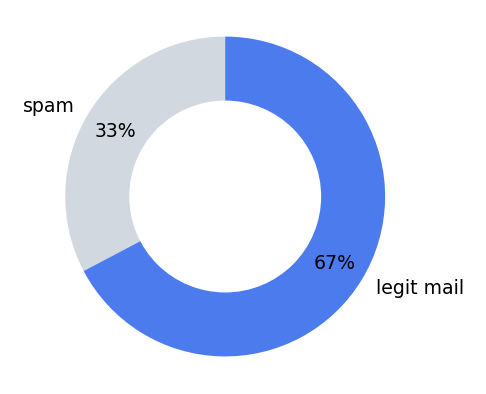

In [29]:
categorynames = ['spam', 'legit mail']
sizes = [amount_of_spam, amount_of_ham]
rang = ['#d1d8e0','#4b7bec']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=categorynames, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%', colors = rang, pctdistance=0.8)

#Drawing a circle on our chart
centre_circle = plt.Circle((0,0), 0.6, fc='white')
plt.gca().add_artist(centre_circle) 
plt.axis('equal')   
plt.show()

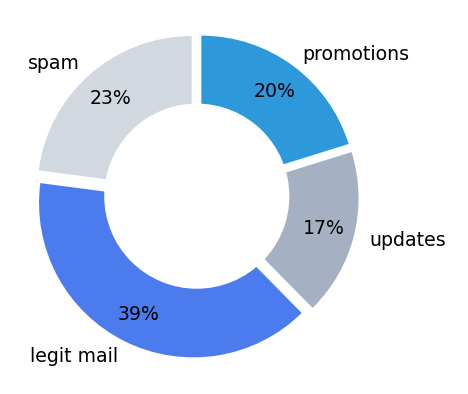

In [30]:
categorynames = ['spam', 'legit mail','updates', 'promotions']
sizes = [25,43,19,22]
rang = ['#d1d8e0','#4b7bec','#a5b1c2','#2d98da']
offset = [0.05,0.05,0.05,0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=categorynames, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%', colors = rang, pctdistance=0.8, explode=offset)

#Drawing a circle on our chart
centre_circle = plt.Circle((0,0), 0.6, fc='white')
plt.gca().add_artist(centre_circle) 
plt.axis('equal')   
plt.show()

# NATURAL LANGUAGE PROCESSING

In [31]:
msg='All work an no play makes jack a dull boy'
msg.lower()

'all work an no play makes jack a dull boy'

## downlad the nltk

In [32]:
#import nltk
#nltk.download('punkt')

# tokenizing


In [32]:
msg='All work an no play makes jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

# Removing stop words

In [34]:
# nltk.download('stopwords')

In [33]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [34]:
type(stopwords)

nltk.corpus.reader.wordlist.WordListCorpusReader

In [35]:
if 'this' in stopwords.words('english'):
  print('yes')

yes


In [36]:
if  'hello' not in stopwords.words('english'):
  print('yes')

yes


In [37]:
msg='All work an no play makes jack a dull boy'
word=word_tokenize(msg.lower())

filtered_words=[]
for w in word:
  if w not in stopwords.words('english'):
    filtered_words.append(w)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy']


# Word Stem and Steming

In [38]:
msg='All work an no play makes jack a dull boy'
word=word_tokenize(msg.lower())

filtered_words=[]
for w in word:
  if w not in stopwords.words('english') and w.isalpha():
    stemmed_word=PorterStemmer().stem(w)
    filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy']


In [39]:
soup = BeautifulSoup((data.at[2,'MESSAGE']), 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!  http://www.adclick.ws/p.cfm?o=315&amp;s=pk007    2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days  http://www.adclick.ws/p.cfm?o=249&amp;s=pk007    3) Get the Child Support You Deserve - Free Legal Advice  http://www.adclick.ws/p.cfm?o=245&amp;s=pk002    4) Join the Web's Fastest Growing Singles Community  http://www.adclick.ws/p.cfm?o=259&amp;s=pk007    5) Start Your Private Photo Album Online!  http://www.adclick.ws/p.cfm?o=283&amp;s=pk007    Have a Wonderful Day,  Offer Manager  PrizeMama                            If you wish to leave this list please use the link below.  http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [40]:
soup.get_text

<bound method PageElement.get_text of 1) Fight The Risk of Cancer!  http://www.adclick.ws/p.cfm?o=315&amp;s=pk007    2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days  http://www.adclick.ws/p.cfm?o=249&amp;s=pk007    3) Get the Child Support You Deserve - Free Legal Advice  http://www.adclick.ws/p.cfm?o=245&amp;s=pk002    4) Join the Web's Fastest Growing Singles Community  http://www.adclick.ws/p.cfm?o=259&amp;s=pk007    5) Start Your Private Photo Album Online!  http://www.adclick.ws/p.cfm?o=283&amp;s=pk007    Have a Wonderful Day,  Offer Manager  PrizeMama                            If you wish to leave this list please use the link below.  http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417>

# Function for Email Processing

In [41]:
def clean_message(message,  stemmer=PorterStemmer(),stop_words = set(stopwords.words('english'))):

    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    clean_text = soup.get_text()
    
    # Convert to lowercase and tokenize
    words = word_tokenize(clean_text.lower())

    # Remove stopwords and punctuation, then stem
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words


In [42]:
clean_message(message=data.at[2,'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

3 APPLY  vleaning and tokenization to all messges

## Slicing Dataframes and Series & Creating Subsets

In [43]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [44]:
data.iloc[4:9]

,MESSAGE,CATEGORY,file_name
doc_id,,,
4,I thought you might like these: 1) Slim Down ...,1,00005.57696a39d7d84318ce497886896bf90d
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html> <head> <title>ReliaQuote - Save Up To...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE? Want To Stop Los...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab


In [45]:
data.MESSAGE.iloc[4:9]

doc_id
4    I thought you might like these:  1) Slim Down ...
5    A POWERHOUSE GIFTING PROGRAM You Don't Want To...
6    Help wanted.  We are a 14 year old fortune 500...
7    <html>  <head>  <title>ReliaQuote - Save Up To...
8    TIRED OF THE BULL OUT THERE?  Want To Stop Los...
Name: MESSAGE, dtype: object

In [46]:
first_emails=data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [47]:
# flat_list=[]
# for sublist in nested_list:
#   for item in sublist:
#     flat_list.append(item)

flat_list=[item for sublist in nested_list for item in sublist]
#first word item is used to append
len(flat_list)

192

In [48]:
flat_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [ ]:
%%time
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
nested_list = data.MESSAGE.apply(clean_message)

CPU times: total: 34.6 s
Wall time: 37.1 s


In [57]:
nested_list.tail()

doc_id
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using logic to slice dataframe

In [58]:
data[data.CATEGORY==1].shape

(1896, 3)

In [59]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY==0].index

In [60]:
doc_ids_ham

Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='doc_id', length=3900)

## Subsetting series with an index

In [61]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [62]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.shape

(1896,)

In [63]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

In [64]:
flat_list_ham=[item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

20826

# Creating a word cloud

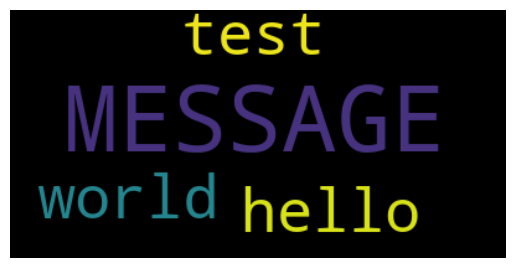

In [65]:
text = "MESSAGE MESSAGE test hello world MESSAGE"

word_cloud = WordCloud().generate(text)

plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [66]:
# nltk.download('gutenberg')
# nltk.download('shakespeare')
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [67]:
word_list = [''.join(word) for word in example_corpus]
novel_as_list = ' '.join(word_list)
novel_as_list

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

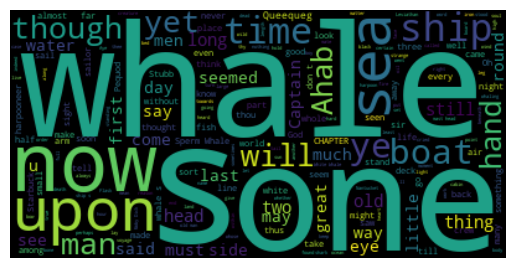

In [68]:
word_cloud = WordCloud().generate(novel_as_list)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

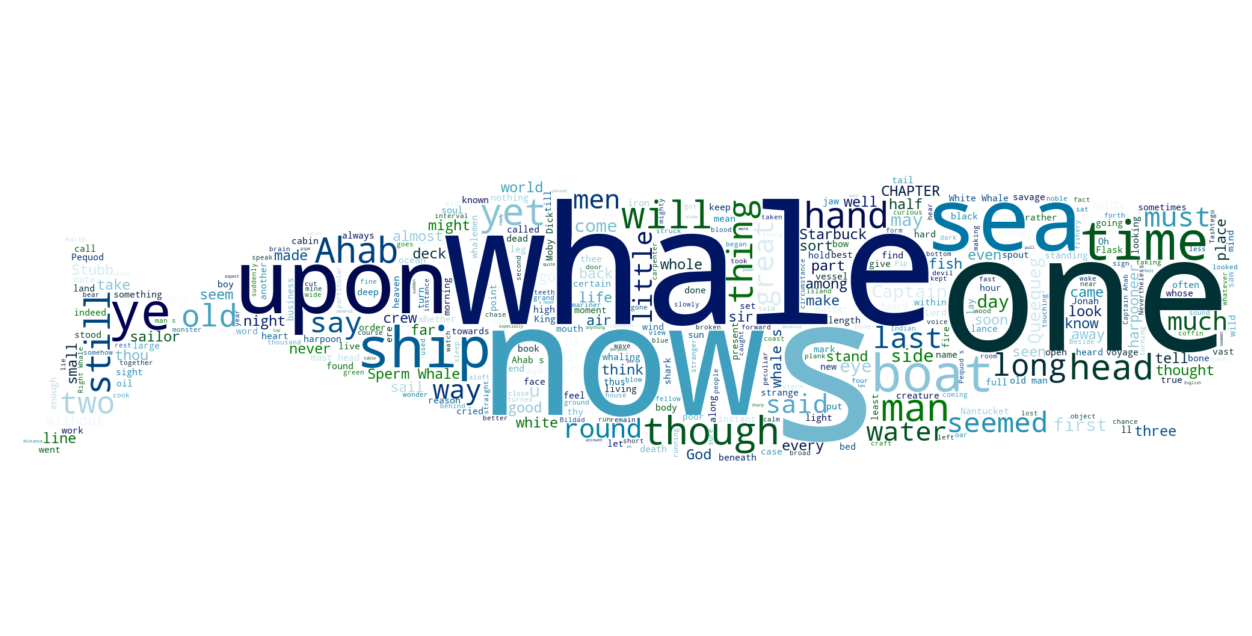

In [69]:
icon = Image.open(whale_file)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean')
word_cloud.generate(novel_as_list)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

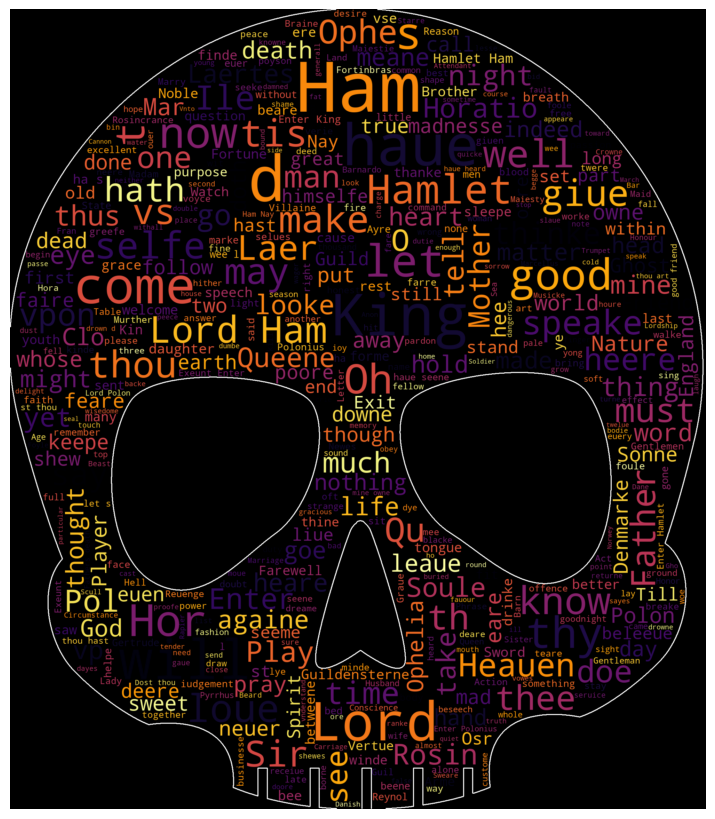

In [71]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

# Load skull mask
skull_icon = Image.open(skull_file)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255,255,255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

# Generate WordCloud
word_cloud = WordCloud(mask=rgb_array, background_color="black", colormap="inferno",              
    contour_color="white", contour_width=2, max_words=500, max_font_size=200,
    random_state=42
)

word_cloud.generate(hamlet_as_string)

# Plot
plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


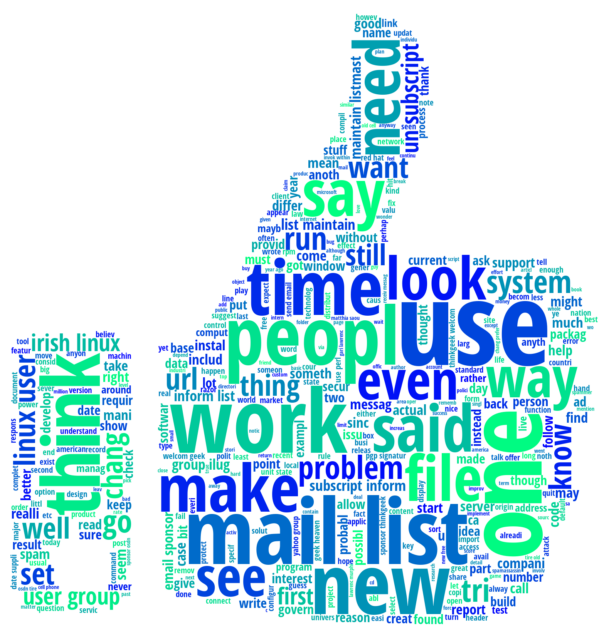

In [72]:
icon = Image.open(thumbs_up_file)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(
    mask=rgb_array,
    background_color='white',
    max_font_size=300,
    max_words=400, 
    colormap='winter',
    font_path=custom_font)

word_cloud.generate(ham_str)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

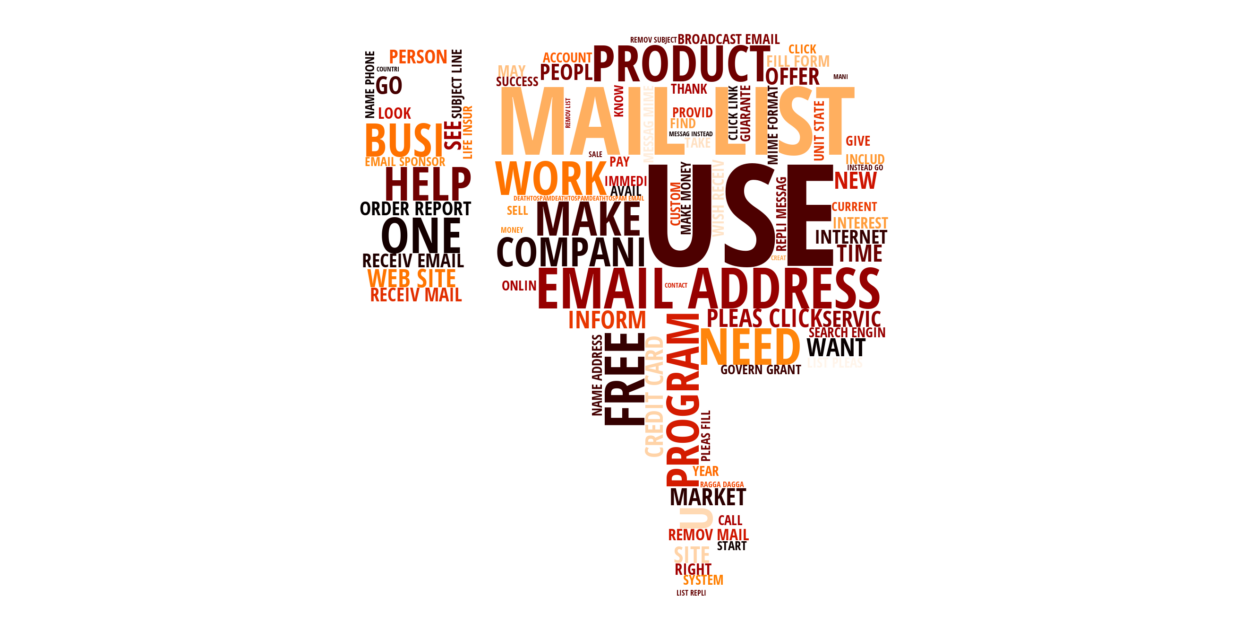

In [73]:
icon = Image.open(thumbs_down_file)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(
    mask=rgb_array,
    background_color='white',
    max_font_size=300,
    max_words=400, 
    colormap='gist_heat',
    font_path=custom_font)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabularly

In [57]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [72]:
unique_words  = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words: ', unique_words.shape[0])
unique_words.head()

Number of unique words:  27346


http     10660
use       5022
list      4856
email     4367
get       4200
Name: count, dtype: int64

In [73]:
frequent_words = unique_words[0:vocab_size]
print('The most Common words \n', frequent_words[:10])

The most Common words 
 http     10660
use       5022
list      4856
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


In [77]:
type(frequent_words)

pandas.core.series.Series

## Create a Vocabulary dataframe with Doc_id

In [74]:
word_ids = range(0,vocab_size)
vocab = pd.DataFrame({'vocab_word': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'word_id'
vocab

,vocab_word
word_id,
0,http
1,use
2,list
3,email
4,get
...,...
2495,till
2496,commerc
2497,bullet


## Save the Vocabularly with csv file

In [75]:
#vocab.to_csv(word_id_file, index_label= vocab.index.name, header = vocab.vocab_word.name)

In [76]:
#to check if a word is in the email
#'learning' in set(vocab.vocab_word)

#email with most number of emails
clean_email_length = [len(sublist) for sublist in stemmed_nested_list]
print('Nr of words in the longest email: ', max(clean_email_length))

print('The email position in the list ', np.argmax(clean_email_length))

Nr of words in the longest email:  7679
The email position in the list  5775


In [77]:
# stemmed_nested_list[np.argmax(clean_email_length)]
# data.at[np.argmax(clean_email_length), 'MESSAGE']

# Generate Features & a Sparse Matrix 
### Creating a Dataframe with one word per column

In [78]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7669,7670,7671,7672,7673,7674,7675,7676,7677,7678
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [83]:
word_columns_df.shape

(5796, 7679)

## Splitting the data into Training & Testing Dataset

In [66]:
x_train, x_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                    test_size=0.3, random_state=42)

In [85]:
print('Number of training samples', x_train.shape[0])

Number of training samples 4057


In [69]:
x_train.index.name = x_test.index.name = 'DOC_ID'

## Create a Sparse Matrix for the Training Data 

In [79]:
#Create an index for a column in datafrfam i.e. vocab_word
word_index =  pd.Index(vocab.vocab_word)

#To get the position
word_index.get_loc('thu')

392

In [80]:
def sparse_matrix(df, index_words, labels):
    nr_rows = df.shape[0]
    nr_col = df.shape[1]
    word_set = set(index_words)

    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_col):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = index_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'OCCURENCE':1 ,
                        'DOC_ID':doc_id, 'WORD_ID':word_id}
                
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [90]:
%%time 
sparse = sparse_matrix(x_train, word_index, y_train)

CPU times: total: 11min 7s
Wall time: 12min 14s


### Combining Occurences with pandas grouby method

In [105]:
trained_group = sparse.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
trained_group.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [81]:
vocab.at[0,'vocab_word']

'http'

In [95]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">  <HTML><HEAD>  <META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=  ype>  <META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>  <BODY><!-- Inserted by Calypso -->  <TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=  ules=3Dnone   style=3D"COLOR: black; DISPLAY: none" width=3D"100%">    <TBODY>    <TR>      <TD colSpan=3D3>        <HR color=3Dblack noShade SIZE=3D1>      </TD></TR></TD></TR>    <TR>      <TD colSpan=3D3>        <HR color=3Dblack noShade SIZE=3D1>      </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=   --><FONT   color=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=  /TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000   face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">  <CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=  0000   face=3D"Copperplate Gothic Bold" size=3D5 P

In [117]:
#To show the Doc_id with every word
trained_group = trained_group.reset_index()
trained_group.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [111]:
vocab.at[1923, 'vocab_word']

'spray'

## Saving Data as txt File

In [ ]:
#np.savetxt(training_data_file, trained_group, fmt='%d')

In [82]:
sparse_test = sparse_matrix(x_test, word_index, y_test)

In [83]:
test_group = sparse_test.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()

In [84]:
np.savetxt(testing_data_file, test_group, fmt='%d')

## A Small Task
#### How many individuals emails were included in testing.txt file? Count the number in txt dataframe. After the splitting and shufflling our  data, how many were included in x_test dataframe? is the number same? if not which were excluded and why? Compare the doc_id values to find out

In [119]:
train_doc_ids = set(trained_group.DOC_ID)
test_doc_id = set(test_group.DOC_ID)

In [121]:
set(x_test.index.values) - test_doc_id

{np.int64(134),
 np.int64(179),
 np.int64(240),
 np.int64(274),
 np.int64(298),
 np.int64(339),
 np.int64(439),
 np.int64(471),
 np.int64(670),
 np.int64(734),
 np.int64(765),
 np.int64(945),
 np.int64(1544),
 np.int64(1670),
 np.int64(1700)}

In [122]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86  Content-Type: text/html; charset="iso-8859-1"  Content-Transfer-Encoding: base64      PGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw  MDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu  ZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9  Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0  aD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm  b250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy  aWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv  eXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh  bmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy  Ij48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz  aXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy  PiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+  IDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo  ZSB3ZWIuPGJyPiANCjwvYj4gPGZvbnQgc2l6ZT0iMiI+Zm9yIG9yZGVycyBv  

In [123]:
data.loc[134]

MESSAGE      ------=_NextPart_000_00E8_85C13B1D.B7243B86  C...
CATEGORY                                                     1
file_name               00135.00e388e3b23df6278a8845047ca25160
Name: 134, dtype: object